# KKBox Customer Churn - Supervised Learning Capstone - Data Loading Methods 

Kaggle Competition: https://www.kaggle.com/c/kkbox-churn-prediction-challenge/data

**Scope:** I am trying to see if a user who is active in February 2017, will still be a user in March 2017

## Import and Preview Data

#### - <font color=blue>Import Libraries</font> -

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import sqlite3 as sql

#### - <font color=blue>Summary of Datasets</font> -
For this project we are given several massive datasets totaling over 30 GB. In general the datasets are divided into two versions: ***v1*** and ***v2***.
_____
**train_v1:** containing the user ids and whether they churned until ***2/28/2017***.

**train_v2:** containing the user ids and whether they churned for the month of ***March 2017***.

Features:
    - msno: user id
    - is_churn: This is the target variable. Churn is defined as whether the user did not continue the subscription within 30 days of expiration. is_churn = 1 means churn,is_churn = 0 means renewal.

_____
**transactions_v1:** transactions of users up until ***2/28/2017***.

**transactions_v2:** transactions of users up until ***3/31/2017***.

Features:
    - msno: user id (***Repeated as a user can have various Transactions***)
    - payment_method_id: payment method
    - payment_plan_days: length of membership plan in days
    - plan_list_price: in New Taiwan Dollar (NTD)
    - actual_amount_paid: in New Taiwan Dollar (NTD)
    - is_auto_renew
    - transaction_date: format %Y%m%d
    - membership_expire_date: format %Y%m%d
    - is_cancel: whether or not the user canceled the membership in this transaction.

_____
**user_log_v1:** transactions of users up until ***2/28/2017***.

**user_log_v2:** transactions of users for the month of ***March 2017***.

Features:
    - msno: user id (***Repeated as a user can have various Logins***)
    - date: format %Y%m%d
    - num_25: # of songs played less than 25% of the song length
    - num_50: # of songs played between 25% to 50% of the song length
    - num_75: # of songs played between 50% to 75% of of the song length
    - num_985: # of songs played between 75% to 98.5% of the song length
    - num_100: # of songs played over 98.5% of the song length
    - num_unq: # of unique songs played
    - total_secs: total seconds played

_____
**members_v3:** All user information data.

Features:
    - msno: user id
    - city
    - bd: age. Note: this column has outlier values ranging from -7000 to 2015, please use your judgement.
    - gender
    - registered_via: registration method
    - registration_init_time: format %Y%m%d

_____

#### - <font color=blue>Dataset Statistics</font> -
**# of Observations**: > 300,000,000

**Dataset Sizes**

- ***train_v1 Dataset:*** 45.56 MB 
- ***train_v2 Dataset:*** 44.56 MB   
- ***transactions_v1 Dataset:*** 1.68 GB     
- ***transactions_v2 Dataset:*** 112.69 MB     
- ***user_log_v1 Dataset:*** 29.78 GB     
- ***user_log_v2 Dataset:*** 1.40 GB 
- ***members_v3 Dataset:*** 417.89 MB
- ***<font color=red>Total:  33.48 GB</font>***


For the most part, ***January 2017 - Train Set*** , ***February 2017 - Validation Set*** data will be coming from the ***v1*** files and ***March 2017 - Test Set*** data will be coming from the ***v2*** files. Although the initial sets will be somewhat limited in features, once we have them imported we will make various queries to create new features.

### - <font color=blue>Import Data into Database</font> -
As described in the 'KKBox Data Loading Methods' Notebook, after working out a succefully lengthy solution completely in Python, I decided to utilize SQLite3 for a more 'Persistent' solution. Postgre was all so considered but this was more practical for the task.

Since the data in each dataset are in different timeframes, the initial Train, Validation, and Test Sets will contain general information for each member. For example:
- The Transaction datset has recorded every single transaction made by a user.
- The User Log dataset has recorded every single time a user has logged onto the platform.

Since these datasets capture different types of user behaviors over different timeframes we can't just join them all together immediately. However since they do capture behavior over time, I believe that there would be a ton of value if we are able to get creative on how we capture this ***retrospective data***. As we go through EDA and Feature Creation we will create these new features through additional queries and python commands.

In [3]:
# Create Connection to SQLite
cnx = sql.connect("C:\J-5 Local SSD\Projects\KKBox Customer Churn\Database\KKBox_DB.db")  # Opens file if exists, else creates file
cur = cnx.cursor()  # This object lets us actually send messages to our DB and receive results
print("Opened database successfully")

Opened database successfully


In [1]:
# # Set file path for all Data
# path = 'C:/J-5 Local SSD/Projects/KKBox Customer Churn/Datasets/'

# # Create list of all dataset names
# data_list = ['train_v1', 'train_v2', "transactions_v1", 'transactions_v2', 'user_logs_v1', 'user_logs_v2', 'members_v3']

# for dset in data_list:
#     for chunk in pd.read_csv(path+dset+'.csv', chunksize=1000000):
#         chunk.to_sql(name=dset, con=cnx, if_exists="append", index=False)  #"name" is name of table 

Now that our datasets are loaded, we will create our Train, Validation, and Test sets respective to their indiviudal months and write them as ***train_jan, valid_feb, test_march.***
    
By creating these sets in our SQLite Database we avoid having to do this in-memory here in this JupyterNB. Also, this is mainly done to simulate working with a massive dataset stored in a database as is expected to happen in practice. Not toy datasets here :) 

Let's get started!

### - <font color=blue>Build out our Datasets</font> -

**How we will build them:**
    
    1) Get all unique users from transactions v1 and v2 with expirations dates falling within each timeframe.
       - Now that we have the basis for each set we will merge continuous merge on msno for each set.

    2) Join members_v3 and all sets on msno

    3.a) Join train_v1 and train_jan on msno

    3.b) Join train_v1 and val_feb on msno 

    4) Join train_v2 and test_mar on msno

This will be all done using SQL commands from this notebook.

**Build all the basis for all three Main Datasets**

In [56]:
# Build all three sets with respect to their respective months and all the users who have Memebership Expirations falling in those months
sets = {'train_jan': ['transactions_v1','20170101','20170101'], 'valid_feb': ['transactions_v1','20170201','20170228'], 'test_mar': ['transactions_v2','20170301','20170331']}

for setname, info in sets.items():  
    cur.execute(f'''CREATE TABLE IF NOT EXISTS {setname} AS
                    SELECT *
                    FROM {info[0]}
                    WHERE membership_expire_date >= {info[1]} AND membership_expire_date <= {info[2]}
    ''')
    
cnx.commit()

In [4]:
# Create list of all table names in DB
alltable_names = [name[0] for name in cur.execute("SELECT name FROM sqlite_master WHERE type='table';")]

# Create a list of all dataset names
datasets = alltable_names[-3:]

**Index msno columns on all tables**

In [19]:
# Index msno columns in all tables, to help with performance moving forward
for table in alltable_names:
    cur.execute(f"CREATE INDEX IF NOT EXISTS msno_idx ON {table}(msno);")
    cnx.commit
    print(f'{table} index created!')


train_v1 index created!
train_v2 index created!
transactions_v1 index created!
transactions_v2 index created!
user_logs_v1 index created!
user_logs_v2 index created!
members_v3 index created!
train_jan index created!
valid_feb index created!
test_mar index created!


**Join members_v3 data onto Main Datasets**

In [36]:
# Make list of member_v3 columns
member_columns = [column[0] for column in cur.execute('select * from members_v3 limit 10').description]
member_columns.remove('msno')

# Create dictionary of member_columns and their datatypes
datatypes = ['INTEGER','INTEGER','TEXT','INTEGER','INTEGER']
member_dict = dict(zip(member_columns, datatypes))

In [34]:
# Create new columns in each Main Dataset to add members_v3 data
for dataset in datasets:
    for column, coltype in member_dict.items():
        cur.execute(f'ALTER TABLE {dataset} ADD COLUMN {column} {coltype};')
        cnx.commit()
        
    print(f'{dataset} Columns have been added')

train_jan Columns have been added
valid_feb Columns have been added
test_mar Columns have been added


In [ ]:
# Join members_v3 and all sets on msno
for dataset in datasets:
    for column, coltype in member_dict.items():
        cur.execute(f'UPDATE {dataset} SET {column} = (SELECT {column} FROM members_v3 WHERE msno = {dataset}.msno)')
        cnx.commit()
    
    print(f'{dataset} Has joined successfully')

**Join train_v1 and train_v2 onto all Main Datasets**

In [ ]:
# Make list of train_v1/train_v2 columns
train_columns = [column[0] for column in cur.execute('select * from train_v1 limit 1').description]
train_columns.remove('msno')

# Create dictionary of member_columns and their datatypes
datatypes = ['INTEGER']
train_dict = dict(zip(train_columns, datatypes))

In [ ]:
# Create new columns in each Main Dataset to add train_v1/train_v2 data
for dataset in datasets:
    for column, coltype in train_dict.items():
        cur.execute(f'ALTER TABLE {dataset} ADD COLUMN {column} {coltype};')
        cnx.commit()
        
    print(f'{dataset} Columns have been added')

In [ ]:
# Join train_v1 and train_jan,valid_feb on msno
for dataset in datasets[:2]:
    for column, coltype in train_dict.items():
        cur.execute(f'UPDATE {dataset} SET {column} = (SELECT {column} FROM train_v1 WHERE msno = {dataset}.msno)')
        cnx.commit()
    
    print(f'{dataset} Has joined successfully')

# Join train_v2 and test_mmar on msno
for dataset in datasets[2]:
    for column, coltype in train_dict.items():
        cur.execute(f'UPDATE {dataset} SET {column} = (SELECT {column} FROM train_v2 WHERE msno = {dataset}.msno)')
        cnx.commit()
    
    print(f'{dataset} Has joined successfully')

### - <font color=blue>Pull Training Data from Database</font> -
Our Train

In [8]:
# Create Connection to SQLite
df = pd.read_sql_query("SELECT * FROM train_jan", cnx)

### Clean Data

#### - <font color=blue>Detect Missing Values in Dataset</font> -

In [1]:
# Table of Features and their respective totals percentages of missing data in both Test and Train sets
total_missing_train = train_jan.isnull().sum().sort_values(ascending=False)
percent_missing_train = (train_jan.isnull().sum()/train_jan.isnull().count())

total_missing_valid = valid_feb.isnull().sum().sort_values(ascending=False)
percent_missing_valid = (valid_feb.isnull().sum()/valid_feb.isnull().count())

total_missing_test = test_mar.isnull().sum().sort_values(ascending=False)
percent_missing_test = (test_mar.isnull().sum()/test_mar.isnull().count())

columns = [total_missing_train, percent_missing_train, total_missing_valid, percent_missing_valid, total_missing_test, percent_missing_test]

missing_data = pd.concat(columns, axis=1, keys=['Total Missing Train', 'Percent Missing Train', 'Total Missing Validation', 'Percent Missing Validation', 'Total Missing Test', 'Percent Missing Test'], sort=False).sort_values(by='Percent Train',ascending = False)
missing_data

NameError: name 'train_jan' is not defined

We notice several things:
- Aside from gender all other missing values seem to be in groups. My initial suspicion is that each group is related to the table in which the data was imported from. 
- When we merged the sets we didnt account for the user's who Churned in train set and is in the Test set. We must remove those.

Let's create a Nullity Matrix to get a better sense of these missing values. What are looking for is to get a better sense at which mechanism is at play (MCAR, MAR, or NMAR). Understanding which one is at play gives us insight on how we handle the missing data. Let's dive in.

https://medium.com/ibm-data-science-experience/missing-data-conundrum-exploration-and-imputation-techniques-9f40abe0fd87

In [50]:
# Convert Train Set into Boolen Values based on whether they are null or not.
missingdata_df = train.columns[train.isnull().any()].tolist()

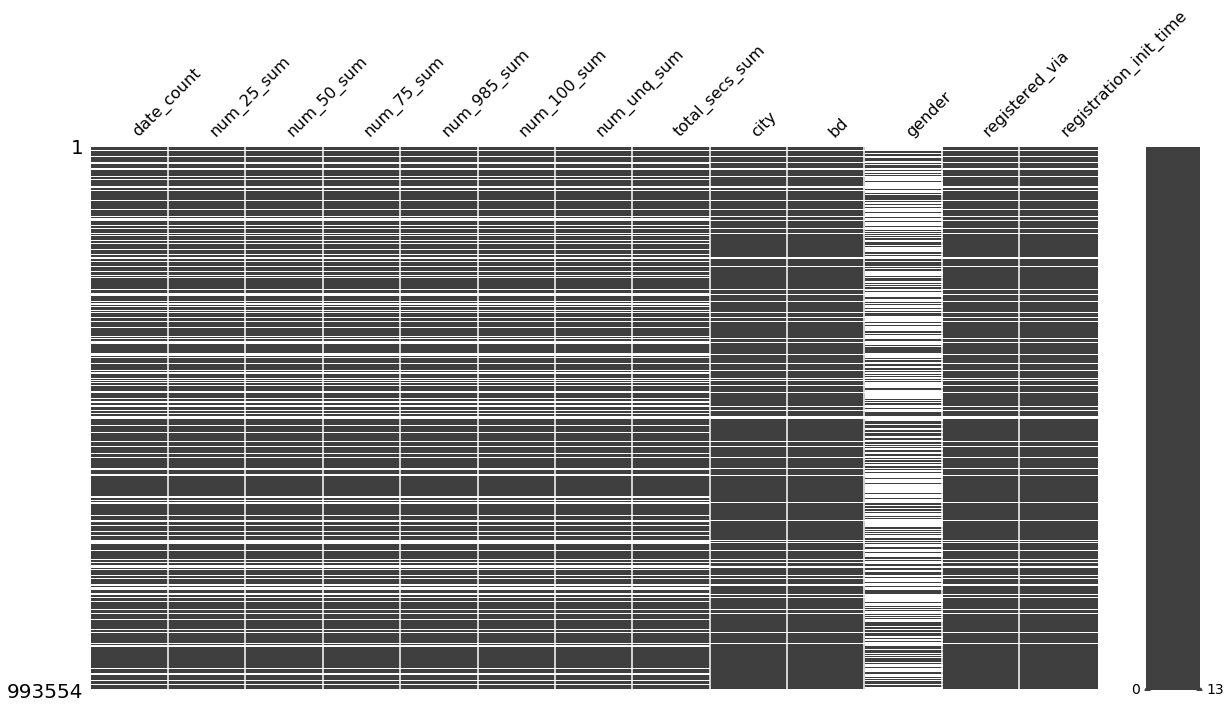

In [74]:
# Nullity matrix for missing Train Set value
msno.matrix(train[missingdata_df], figsize=(20,10))

In [ ]:
# check data types and make sure they are correct



In [89]:
# print all values that cannot be converted to float
for column_name in ["num_25_sum"]:
    print(f"These are the problematic values for the variable: {column_name}")
    for value in train[column_name]:
        try:
            float(value)
        except:
            print(value)

These are the problematic values for the variable: num_25_sum


In [ ]:
# inspect rows where num_25_sum, ... are null



#### - <font color=blue>Handle Missing Values in Dataset</font> -

We have 5 features that seem to be missing a significant chunk of data. Of the 5, 4 of these features seem to be missing the same exact amount of data. Since I am not in contact with the KKBox to futher investigate this issue I will be dropping these 5 features as any sort of "naive" Imputation or Interpolation would be irresponsible. 

Although I am curious what would happen if we added fillers for the missing values:
- Run initial model with features removed
- Then set missing data to -99, run Random Forest. Only works with RF

In [ ]:
# Remove any column above threshold of missing values, Make a Copy
train = train.drop(columns=train.columns[train.isnull().sum() / train.shape[0] > .1], axis=1)
test = test.drop(columns=test.columns[test.isnull().sum() / test.shape[0] > .1], axis=1)

In [ ]:
# Remove any column above threshold of missing values, Make a Copy
train = train.drop(columns=train.columns[train.isnull().sum() / train.shape[0] > .1], axis=1)
test = test.drop(columns=test.columns[test.isnull().sum() / test.shape[0] > .1], axis=1)

### Exploratory Data Analysis

As we are dealing with and extremely large datasets and we are provided with both a Train and a Test set already. Each of which have roughly 1,000,000 observations.
In light of this we will be performing EDA on both sets. The test set will purely be used to understand the relationship between the two. The test set WILL NOT be used for Modeling and Training purposes. Here is the overall structure on how we approach this projected.

As this is real company data I want to make this analysis as authentic as possible. It also important to note that since we are dealing with ~1,000,000 observations we may need to take a statified subset of our training data in improve performance on visualizations.

***Data Split Strategy***
- ~20-30% Stratified Sampling on Train Set for EDA
- 50/50 Split on Train set for Feature Selection, Modeling Decisions, and Model Training and Tuning
- Validation Set for validation
- Test Set for testing

#### - <font color=blue>Create Stratified Sampled EDA Train Set</font> -

In [44]:
# Specificy X and y
y = train['is_churn']
X = train.drop('is_churn', axis=1)

In [47]:
# Split into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [ ]:
# Merge X_train and X_test into a single train set
train_strat = pd.concat([X_train,y_train], axis=1)
train_strat.shape()

#### - <font color=blue>Split Feautres by Categorical or Continuous</font> -

In [ ]:
# Split features into respective groups to make EDA and Transformations Easier
date_feats = ['transaction_date', 'membership_expire_date']
cont_feats = ['num_25', 'num_50','num_75', 'num_985', 'num_100', 'num_unq', 'total_secs','payment_method_id','plan_list_price', 'actual_amount_paid', 'payment_plan_days']
cat_feats = ['is_cancel', 'is_auto_renew', 'payment_method_id']

In [ ]:
# Split features into respective groups to make EDA and Transformations Easier
date_feats = ['transaction_date', 'membership_expire_date']
cont_feats = ['payment_method_id','plan_list_price', 'actual_amount_paid', 'payment_plan_days']
cat_feats = ['is_cancel', 'is_auto_renew', 'payment_method_id']

#### - <font color=blue>Inspect Target Variable</font> -

In [ ]:
# Print out Binary counts and their relative frequency
totals = train_strat['is_churn'].value_counts() 
relative = train_strat['is_churn'].value_counts() / train_strat['is_churn'].value_counts().sum()

pd.concat([totals, relative], axis=1, keys=['Total Count', 'Relative %'])

We can see that there is clear and large class imbalance between users who churn and those which do not. Although we will continue the EDA phase with this data so we can be true with the 'population, we will need to consider an even resampling of our data when it comes to Parameter Tuning and Model Training. This large of a class imbalance may drown out what makes a customer churn and thus defeat the purpose of this analysis.

#### - <font color=blue>Continuous Feature Univariate Analysis</font> -

First we will start of by inspecting each continuous features individually to get a sense of its distribution. Then we will compare these features against our Target Variable to see if we can uncover any insights on relationships

In [ ]:
# Display Histogram for each Continuous Feature
plt.figure(figsize=(20,40))
for index, column in enumerate(cont_feats):
    plt.subplot(11,4,index+1)
    plt.hist(train_strat[column], bins=150)
    plt.title(f"{column} Distribution")
    plt.xlabel(f'{column}')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Many of these distributions are significantly skewed and I am suspecting that we will see a considerable amount of outliers. Let's Calculate a 5-Number Summary to get a better sense of the distribution.

In [ ]:
# Calculate a 5-Number summary for each Continuous Varaible
train_strat[cont_feats].describe()

As expected we can see that outliers are present in many of our skewed distributions. Lets look at these features in comparison with are Target Variable.

#### - <font color=blue>Target Variable vs Continuous Features</font> -

In [ ]:
plt.figure(figsize=(20,40))

for index, column in enumerate(cont_feats):
    plt.subplot(11,4,index+1)
    sns.boxplot(train_strat['is_churn'],train_strat[column])
    plt.title(f"Customer Churn vs {column}")
    plt.ylabel(column)
    plt.xlabel('Customer Churn')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

Originially I felt that our data might contain a lot of outliers. However, n second thought I do not think these are outliers. Based on 'how many' and 'how close' these visual outliers are, we could very well be looking at exponential distribution with very long tails.

Let's leave these distributions as-is for a baseline of our model and then we will consider transformation if necessary.

#### - <font color=blue>Categorical Feature Univariate Analysis</font> -

In [ ]:
plt.figure(figsize=(20,40))

for index, column in enumerate(cat_feats):
    plt.subplot(11,4,index+1)
    
    # bar chart of a categorical column
    plt.bar(train_strat.groupby(column)[column].count().index, train_strat.groupby(column)[column].count(), 
             color=["red","green","blue","grey","pink"])
    plt.title(f"{column} Bar Plot")
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
print(stats.chisquare(count_table, axis=None))

#### - <font color=blue>Target Variable vs Categorical Features</font> -

In [ ]:
# create crosstab: gender by race/ethnicity
for feature in cat_feats:
    print(f'''
Customer Churn vs {feature}
{pd.crosstab(train_strat["is_churn"], train[feature])}
''')

In [ ]:
# Plot counts for each combination of levels.
plt.figure(figsize=(20,40))

for index, column in enumerate(cat_feats):
    plt.subplot(11,4,index+1)
    sns.countplot(x=column, hue="is_churn", data=train_strat, palette="Greens_d")
    plt.title(f"Customer Churn vs {column}")
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
# Conduct Chi-square Test of Independence.
# Does user churn affect the probability of being part of a specific category
# Ho: Categories are not Independent
from scipy.stats import chi2_contingency
import numpy as np

# Create Contingency Table and Run test
for feature in cat_feats:
    obs = np.array([train_strat['is_churn'], train_strat[feature]])
    chi2, p, dof, expected = chi2_contingency(obs)
    
    print(f'''
    Chi-Square ToI: is_churn vs {feature}
    chisquare stat = {chi2}
    p-Value = {p}
    Deg. of freedom = {dof}
    expected frequencies = {expected}''')

### Feature Creation

If we read through the description of each feature, we can get creative and create some new features that may be of use.

You can create more features from this processed user_logs file:

    Mean/median/standard_dev for each column.
    Number of completed songs against incomplete songs
    Duration of membership
    Number of repeated songs
    Number of times user has logged on


In [ ]:
# Create empty lists to store new feature names
new_cont = []
new_cat = []

#### - <font color=blue> New Features from SQL Database </font> -

In [ ]:
country_table = pd.read_sql_query("SELECT * FROM Country", con)

#### - <font color=blue> New Features from Training Set </font> -

**discount**: a column to see how much discount was offered to the customer.

In [ ]:
train_strat['discount'] = train_strat['plan_list_price'] - train_strat['actual_amount_paid']
new_cont.append('discount')

**is_discount**: a column to see if a discount was offered to the customer.

In [ ]:
train_strat['is_discount'] = train_strat['discount'].apply(lambda x: 1 if x > 0 else 0).astype(np.int8)
new_cat.append('is_discount')

**autorenew_&_not_cancel**: A binary feature to see whether members have auto renewed and not cancelled at the same time.

In [ ]:
train_strat['Autorenew_&_notCancel'] = ((train_strat['is_auto_renew'] == 1) == (train_strat['is_cancel'] == 0)).astype(np.int8)
new_cat.append('Autorenew_&_notCancel')

**notAutorenew_&_cancel**: A binary feature to see whether members have NOT auto renewed and cancelled at the same time.

In [ ]:
train_strat['notAutorenew_&_cancel'] = ((train_strat['is_auto_renew'] == 0) == (train_strat['is_cancel'] == 1)).astype(np.int8)
new_cat.append('notAutorenew_&_cancel')

**membership_duration**: How long is left on their current membership after the most recent transaction.

In [ ]:
# difference in days
train_strat['membership_duration_remain'] = train_strat['membership_expire_date'] - train_strat['transaction_date']
train_strat['membership_duration_remain'] = (train_strat['membership_duration_remain'] / np.timedelta64(1, 'D')).astype(int)
new_cont.append('membership_duration_remain')

#### - <font color=blue> NEW Continuous Feature Univariate Analysis</font> -

In [ ]:
# Display Histogram for each Continuous Feature
plt.figure(figsize=(20,40))
for index, column in enumerate(new_cont):
    plt.subplot(11,4,index+1)
    plt.hist(train_strat[column], bins=100)
    plt.title(f"{column} Distribution")
    plt.xlabel(f'{column}')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

#### - <font color=blue>Target Variable vs NEW Continuous Features</font> -

In [ ]:
plt.figure(figsize=(20,40))

for index, column in enumerate(new_cont):
    plt.subplot(11,4,index+1)
    sns.boxplot(train_strat['is_churn'],train_strat[column])
    plt.title(f"Customer Churn vs {column}")
    plt.ylabel(column)
    plt.xlabel('Customer Churn')
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

#### - <font color=blue>NEW Categorical Feature Univariate Analysis</font> -

In [ ]:
plt.figure(figsize=(20,40))

for index, column in enumerate(new_cat):
    plt.subplot(11,4,index+1)
    
    # bar chart of a categorical column
    plt.bar(train_strat.groupby(column)[column].count().index, train_strat.groupby(column)[column].count(), 
             color=["red","green","blue","grey","pink"])
    plt.title(f"{column} Bar Plot")
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

#### - <font color=blue>Target Variable vs NEW Categorical Features</font> -

In [ ]:
# Plot counts for each combination of levels.
plt.figure(figsize=(20,40))

for index, column in enumerate(new_cat):
    plt.subplot(11,4,index+1)
    sns.countplot(x=column, hue="is_churn", data=train_strat, palette="Greens_d")
    plt.title(f"Customer Churn vs {column}")
    plt.ylabel('Count')
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

#### - <font color=red>How can I interpret these???</font> -


### Feature Selection

#### - <font color=blue>Data Pre-Processing</font> -

First we will need to add our new features to the parent dataset. Once we do this we will need to split our data into a balanced sample set. We will use this dataset for Feature Selection, Modeling Decisions, and Model Training.

In [ ]:
# add discount feature to Train and Test parent datasets
train['discount'] = train['plan_list_price'] - train['actual_amount_paid']
test['discount'] = test['plan_list_price'] - test['actual_amount_paid']

# add is_discount feature to parent dataset
train['is_discount'] = train['discount'].apply(lambda x: 1 if x > 0 else 0).astype(np.int8)
test['is_discount'] = test['discount'].apply(lambda x: 1 if x > 0 else 0).astype(np.int8)

# add autorenew_&notcancel feature to parent dataset
train['Autorenew_&_notCancel'] = ((train['is_auto_renew'] == 1) == (train['is_cancel'] == 0)).astype(np.int8)
test['Autorenew_&_notCancel'] = ((test['is_auto_renew'] == 1) == (test['is_cancel'] == 0)).astype(np.int8)

# add notAutorenew_&_cancel feature to parent dataset
train['notAutorenew_&_cancel'] = ((train['is_auto_renew'] == 0) == (train['is_cancel'] == 1)).astype(np.int8)
test['notAutorenew_&_cancel'] = ((test['is_auto_renew'] == 0) == (test['is_cancel'] == 1)).astype(np.int8)

# add membership_duration_remain feature to parent dataset
train['membership_duration_remain'] = train['membership_expire_date'] - train['transaction_date']
train['membership_duration_remain'] = (train['membership_duration_remain'] / np.timedelta64(1, 'D')).astype(int)
test['membership_duration_remain'] = test['membership_expire_date'] - test['transaction_date']
test['membership_duration_remain'] = (test['membership_duration_remain'] / np.timedelta64(1, 'D')).astype(int)


# Add Continuous Columns names to cont_feats list
cont_feats.append('discount')
cont_feats.append('membership_duration_remain')

# Add Continuous Columns names to cat_feats list
cat_feats.append('is_discount')
cat_feats.append('Autorenew_&_notCancel')
cat_feats.append('notAutorenew_&_cancel')

In [ ]:
# Create balanced dataset with equal samples of our Target Variable
from sklearn.utils import resample

# Separate train set via is_churn = 0 and 1
train_churn_0 = train[train['is_churn']==0]
train_churn_1 = train[train['is_churn']==1]
 
# Sample when is_churn = 0
train_churn_0 = resample(train_churn_0, 
                         replace=False,     # sample without replacement
                         n_samples=10000)    # to match majority class

# Sample when is_churn = 1
train_churn_1 = resample(train_churn_1, 
                         replace=False,     # sample without replacement
                         n_samples=10000)    # to match majority class
 
# Combine both sample sets to make one large 50/50 split
train_churn_5050 = pd.concat([train_churn_0, train_churn_1])
 
# Display new class counts to check 
train_churn_5050['is_churn'].value_counts()

#### - <font color=blue>Feature Selection</font> -

1) Drop highly correlated continuous features.
- Inspect via correlation and heatmap

### Model Pre-Processing

#### - <font color=blue>Train Test Split</font> -

In [ ]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

#### - <font color=blue>Feature Scaling</font> -

In [ ]:
Scale all features

----